## Introduction:
The goal of this project is to establish a robust intelligent system to aid in value investing efforts using stock market data. The system will help make investment decisions and based on intrinsic value of companies. It will not, however, trade on the basis of daily market volatility. This project is a part 2 of a series of 7 companies. At the end of the project we will be able to:


1.   Predict stock price valuations on a daily, weekly and monthly basis
2.   Recommend to buy, sell or hold based on certain decision parameters
3.   Maximize capital returns, minimise loses, and minise hold periods

Loading Libraries and Data For Russia - Sberbank Rossii PAO

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
sheet_id = '1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk'
url = 'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_id}'.format(sheet_id=sheet_id)
df = pd.read_csv(url)

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",291.02,294.00,294.42,290.26,47.00M,-0.76%
1,"Mar 30, 2021",293.25,294.86,295.72,291.50,38.81M,-0.02%
2,"Mar 29, 2021",293.30,289.72,294.09,289.26,43.68M,0.71%
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07M,1.59%
4,"Mar 25, 2021",286.66,286.50,287.03,283.85,35.22M,0.30%


In [ ]:
df.shape

(311, 7)

In [ ]:
df.isna().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

## Data Wrangling

In [ ]:
df.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00M,-0.76%
2021-03-30,293.25,294.86,295.72,291.50,38.81M,-0.02%
2021-03-29,293.30,289.72,294.09,289.26,43.68M,0.71%
2021-03-26,291.22,288.63,292.75,288.32,56.07M,1.59%
2021-03-25,286.66,286.50,287.03,283.85,35.22M,0.30%


## Exploratory Data Analysis

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
def remove_string(data, column, item):
  data[column] = df[column].str.replace(item, '').astype(float)
  return data[column].dtype

In [ ]:
remove_string(df, 'Change %', '%')
remove_string(df, 'Vol.', 'M')


dtype('float64')

In [ ]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.76
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.02
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.71
2021-03-26,291.22,288.63,292.75,288.32,56.07,1.59
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.30


In [ ]:
y = df['Price']

In [ ]:
type(y)

pandas.core.series.Series

In [ ]:
y.describe()

count    311.000000
mean     234.524019
std       32.079847
min      174.270000
25%      207.700000
50%      229.140000
75%      264.380000
max      293.300000
Name: Price, dtype: float64

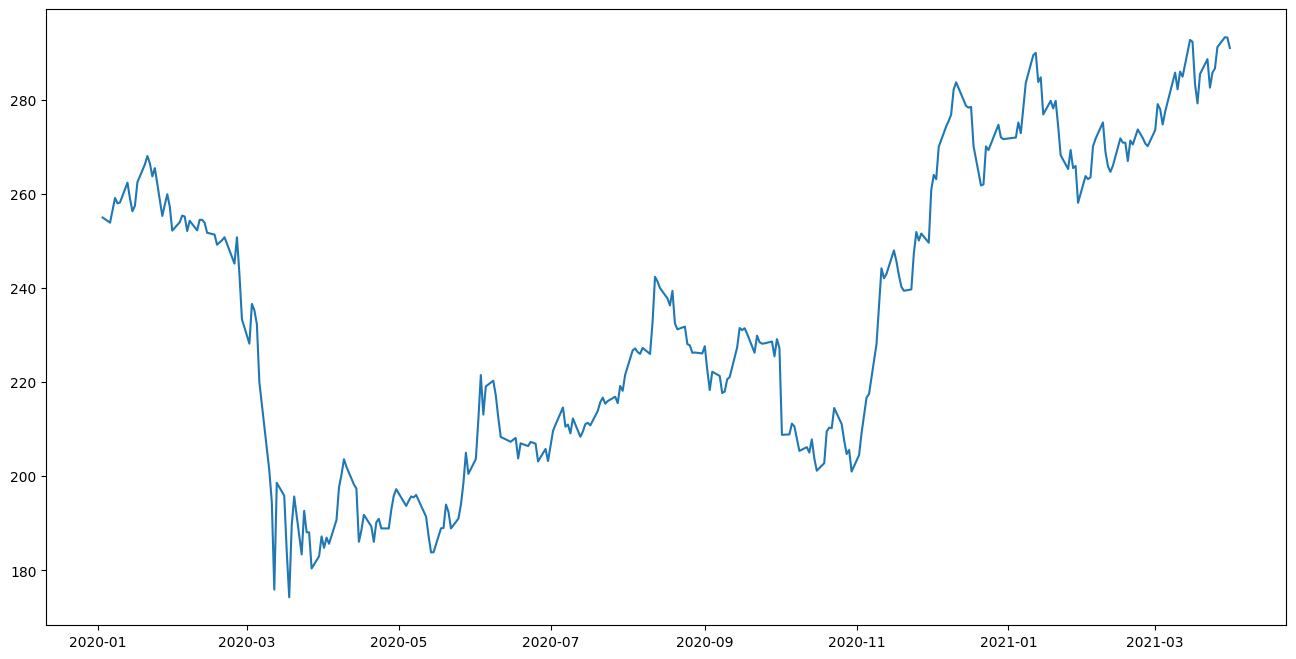

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y)
plt.show()

In [ ]:
decomp = seasonal_decompose(df['Price'], model='additive', period=90)
seasonal = decomp.seasonal
trend = decomp.trend
residual = decomp.resid

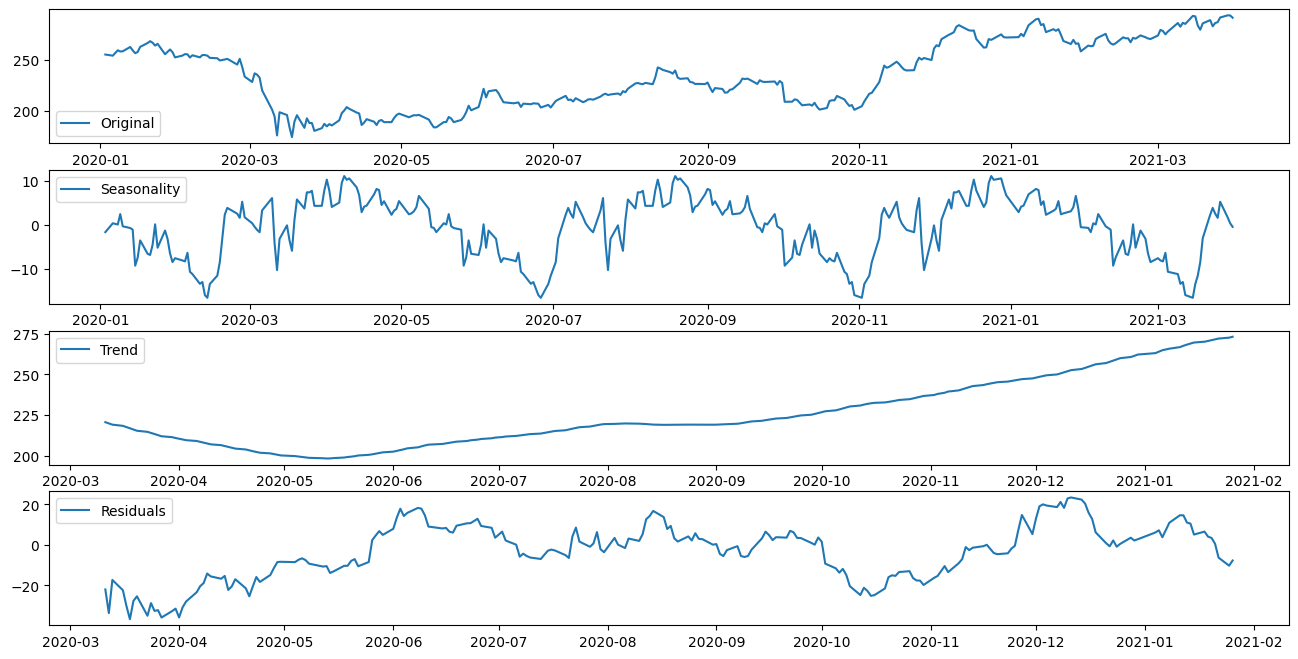

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['Price'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.show()

## Testing For Stationarity

In [ ]:
from statsmodels.tsa.stattools import kpss
kpss_stat, p_value, n_lags, critical_value = kpss(df['Price'])
def stationarity_check(value):
    if value < 0.05:
        print("Data is not stationary")
    else:
        print("Data is stationary")
stationarity_check(p_value)

Data is not stationary


<ipython-input-19-f210059bdee2>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, n_lags, critical_value = kpss(df['Price'])


In [ ]:
df['price_diff'] = df['Price'].diff()
df = df.dropna()

In [ ]:
df['rolling_mean_diff'] = df['price_diff'].rolling(window=5).mean()
df = df.dropna()

In [ ]:
df.head()

,Price,Open,High,Low,Vol.,Change %,price_diff,rolling_mean_diff
Date,,,,,,,,
2021-03-24,285.79,283.40,288.00,282.25,46.41,1.13,-0.87,-1.046
2021-03-23,282.60,287.56,288.30,282.11,70.76,-2.10,-3.19,-2.130
2021-03-22,288.65,285.00,291.20,283.08,62.76,1.11,6.05,-0.930
2021-03-19,285.47,279.00,286.31,278.03,84.25,2.23,-3.18,-1.150
2021-03-18,279.25,284.04,285.79,278.24,74.13,-1.45,-6.22,-1.482


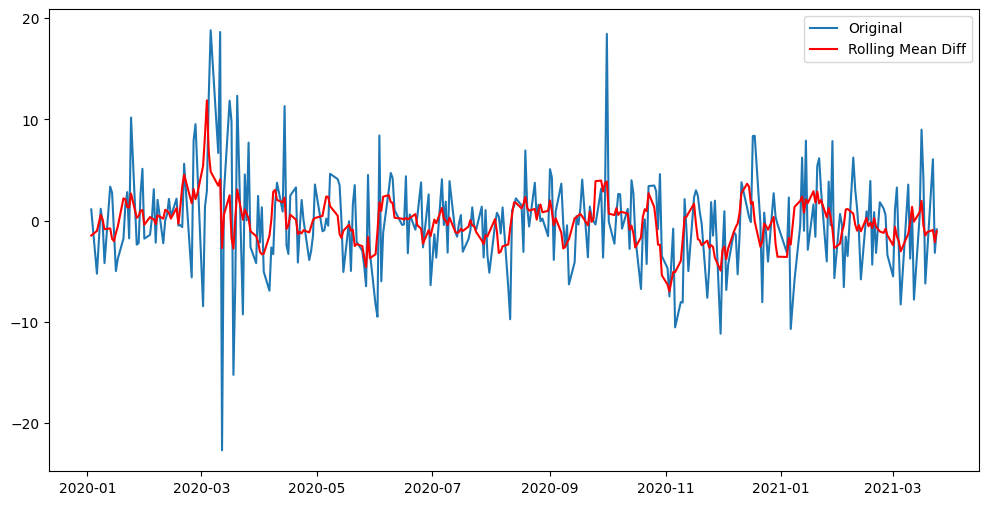

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['price_diff'], label='Original')
plt.plot(df['rolling_mean_diff'], color='red', label='Rolling Mean Diff')
plt.legend()
plt.show()


In [ ]:
stationarity_check(kpss(df['rolling_mean_diff'])[1])

Data is stationary


In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
df_train = df.loc['2020-01-01':'2021-01-01']
df_test = df.loc['2021-01-01':]


## Creating The ARIMA Model

In [ ]:
def evaluate_arima_model(data, arima_order):
  train = data.loc['2020-01-01':'2021-01-01']['rolling_mean_diff'].values
  test = data.loc['2021-01-01':]['rolling_mean_diff'].values
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    future = model_fit.forecast()[0]
    predictions.append(future)
    history.append(test[t])
  error = mean_squared_error(test, predictions)
  return error

## Finding The Right ARIMA Order For The Model

In [ ]:
def evaluate_model(data, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          mse = evaluate_arima_model(data, order)
          if mse < best_score:
            best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order,mse))
        except:
          continue
  return print("Best ARIMA%s MSE=%.3f" % (best_cfg, best_score))

In [ ]:
p_values = [x for x in range(0, 5)]
d_values = [x for x in range(0, 5)]
q_values = [x for x in range(0, 5)]

In [ ]:
#evaluate_model(df_train['rolling_mean_diff'], p_values, d_values, q_values)

In [ ]:
p = 1
d = 2
q = 1
model = ARIMA(df_train['rolling_mean_diff'], order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(df_test))

# Plotting The Fitted Model

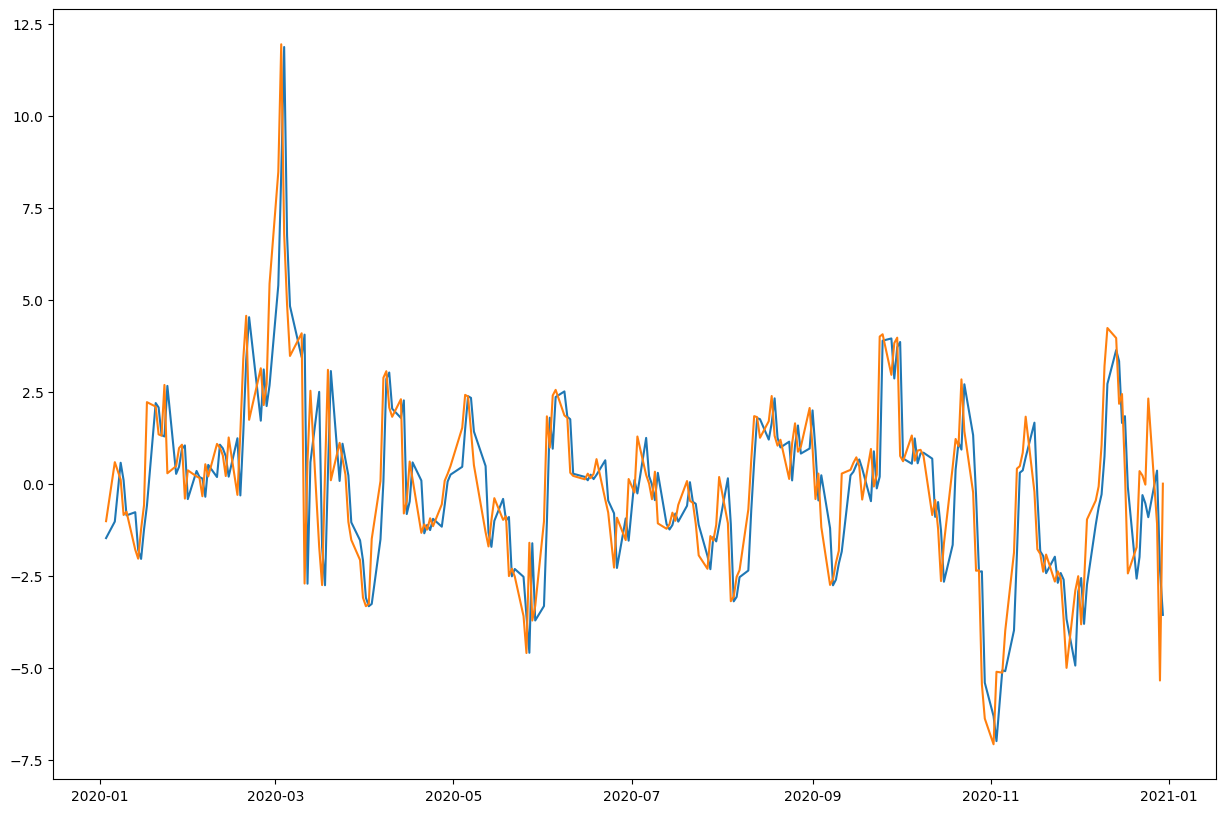

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df_train['rolling_mean_diff'])
plt.plot(model_fit.predict())
plt.show()

# Plotting The Forecast

In [ ]:
future_cast = model_fit.forecast(len(df_test))
future_cast.index = df_test.index
future_cast = pd.DataFrame(future_cast)
future_cast.columns = ['rolling_mean_diff']

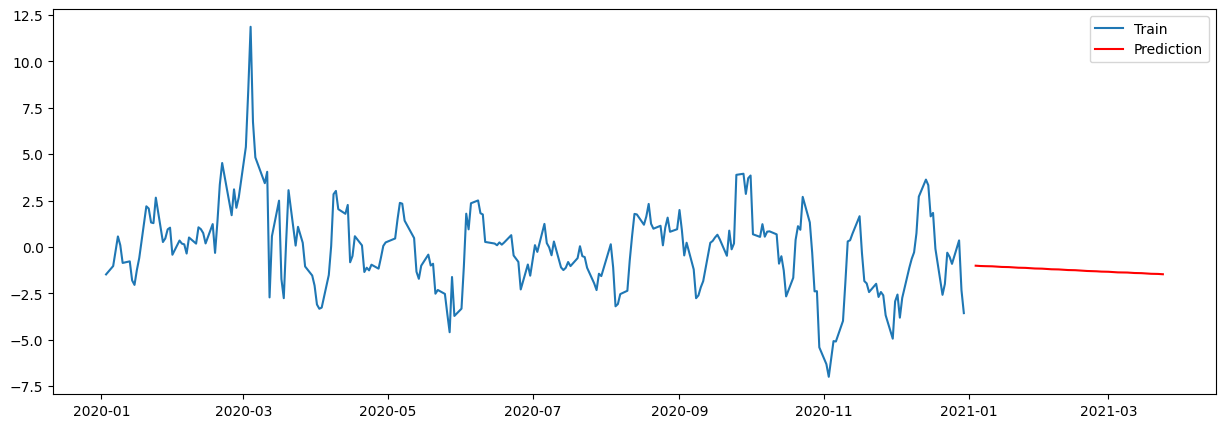

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['rolling_mean_diff'], label='Train')
plt.plot(future_cast['rolling_mean_diff'], color='red', label='Prediction')
plt.legend()
plt.show()

## Back Testing The Model

In [ ]:
def evaluate_arima_model(data, arima_order, start_train_size):
    history = list(data[:start_train_size])
    predictions = []
    for t in range(start_train_size, len(data)):

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(7)[-1]
        predictions.append(future)
        history.append(data[t])
    mse = mean_squared_error(data[start_train_size:], predictions)
    mae = mean_absolute_error(data[start_train_size:], predictions)

    return mse , mae, predictions


In [ ]:
mse, mae, predictions = evaluate_arima_model(df['rolling_mean_diff'].sort_index(), (1, 2, 1), len(df_train))

## Plotting The Forecast With Bollinger Bands

In [ ]:
forecast = pd.DataFrame(predictions)
forecast.columns = ['rolling_mean_diff']
forecast.index = df_test.index[::-1]
forecast.head()

,rolling_mean_diff
Date,
2021-01-04,-3.626643
2021-01-05,-3.657335
2021-01-06,-1.722661
2021-01-08,-2.395069
2021-01-11,1.397644


In [ ]:
f_std = forecast['rolling_mean_diff'].std()

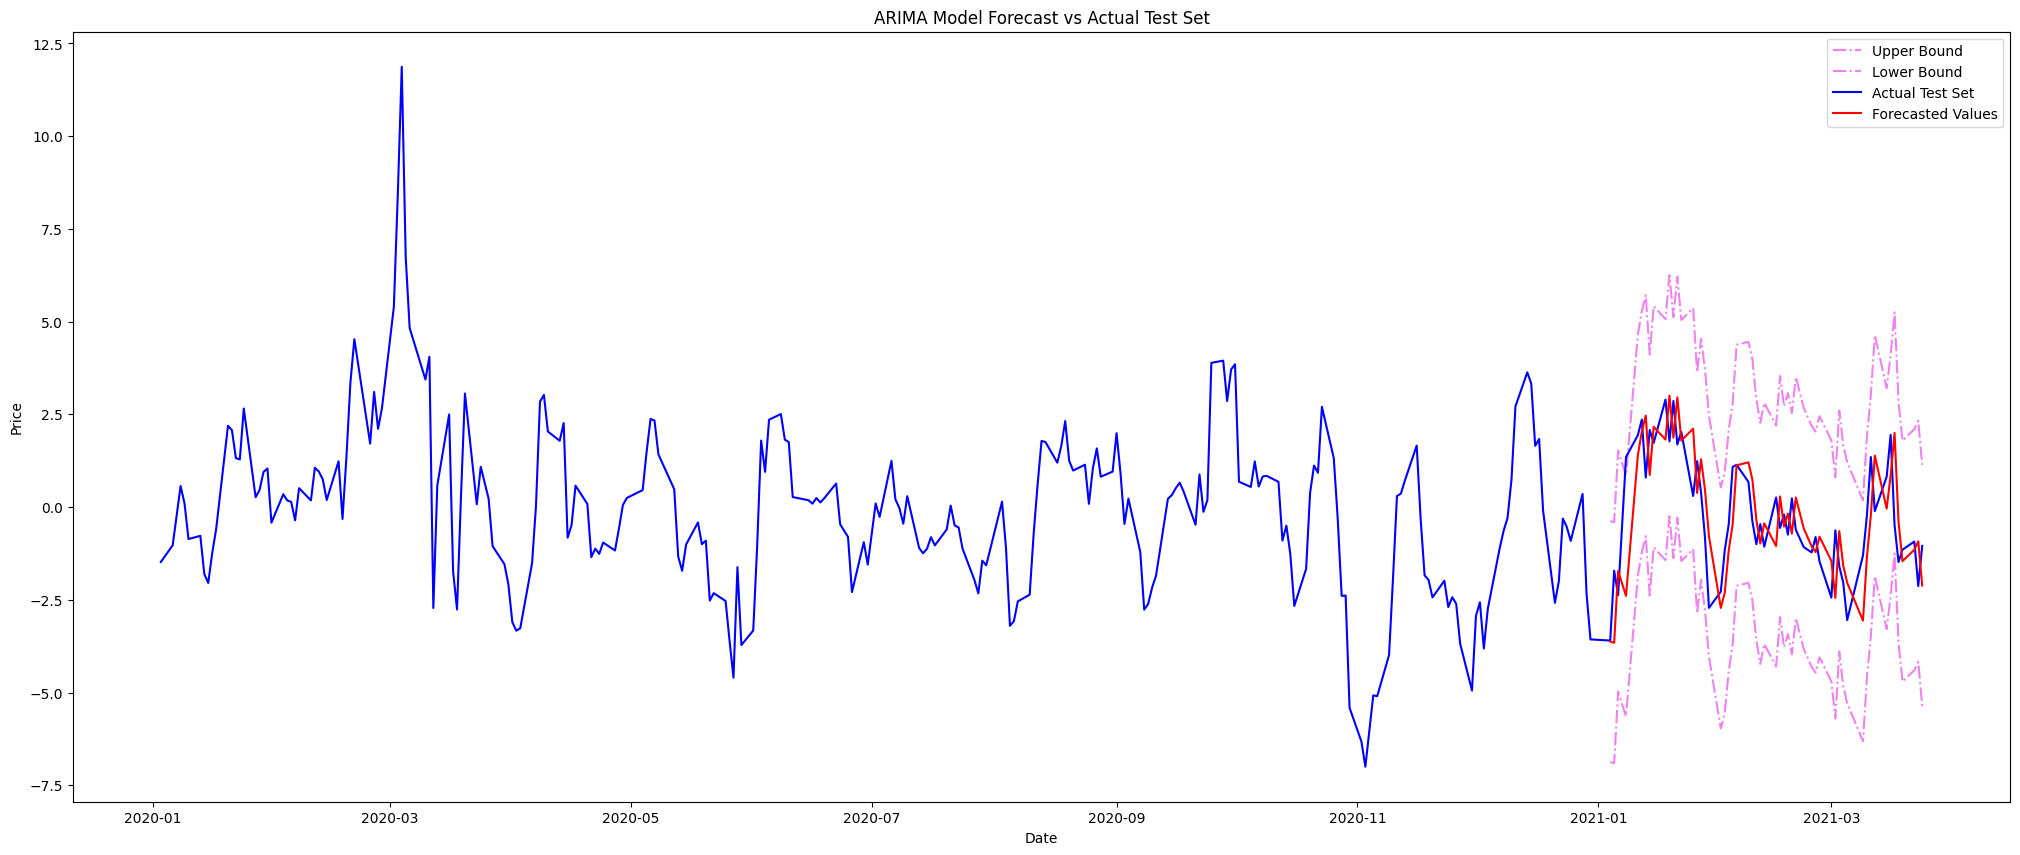

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(forecast['rolling_mean_diff'] + 1.96*f_std, label='Upper Bound', color='violet', linestyle='-.')
plt.plot(forecast['rolling_mean_diff'] - 1.96*f_std, label='Lower Bound', color='violet', linestyle='-.')

plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

plt.plot(forecast, label='Forecasted Values', color='red')

plt.title('ARIMA Model Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Decisions: Buy, Hold, Sell?

In [ ]:
o_std = df['rolling_mean_diff'].std()

In [ ]:
def buy_sell_hold(forecast, look_ahead, data, threshold=1.96):
  standard_dev = data['rolling_mean_diff'].std()
  decisions = []
  open_prices = []
  dates = []
  buy_sell_flag = 'buy'
  for i in range(len(forecast) - look_ahead):
    if standard_dev is None:
      return "Please provide standard deviation"
    else:
      open_prices.append(data['Open'].iloc[i])
      dates.append(forecast.index[i])
      if (forecast.iloc[i + look_ahead] > forecast.iloc[i] + threshold * standard_dev) & (buy_sell_flag != 'buy'):
        decisions.append('buy')
        buy_sell_flag = 'buy'
      elif (forecast.iloc[i + look_ahead] < forecast.iloc[i] - threshold * standard_dev) & (buy_sell_flag != 'sell'):
        decisions.append('sell')
        buy_sell_flag = 'sell'
      else:
        decisions.append('hold')
  df = pd.DataFrame({'Decision': decisions, 'Open': open_prices}, index=dates)
  return df

In [ ]:
decision_df = buy_sell_hold(forecast['rolling_mean_diff'], look_ahead=7, data=df, threshold=0.1)

In [ ]:
decision_df.head(30)

,Decision,Open
2021-01-04,hold,283.40
2021-01-05,hold,287.56
2021-01-06,hold,285.00
2021-01-08,hold,279.00
2021-01-11,hold,284.04
2021-01-12,hold,292.35
2021-01-13,sell,293.06
2021-01-14,buy,286.05
2021-01-15,sell,286.30
2021-01-18,hold,283.84


In [ ]:
def decision_score(lst):
  score = 0
  for i in range(len(lst)):
    if lst[i] == 'buy':
      score += 1
    elif lst[i] == 'sell':
      score -= 1
    else:
      score += 0
  return score

In [ ]:
decision_score(decision_df['Decision'])

-1